Installing Kaggle API and downloadig the dataset from kaggle and extract it

In [1]:
# Install Kaggle API
%pip install kaggle

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Extract the dataset
import zipfile
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')

Note: you may need to restart the kernel to use updated packages.
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other




  0%|          | 0.00/2.29G [00:00<?, ?B/s]
  0%|          | 1.00M/2.29G [00:00<12:32, 3.27MB/s]
  0%|          | 3.00M/2.29G [00:00<04:54, 8.36MB/s]
  0%|          | 6.00M/2.29G [00:00<02:56, 14.0MB/s]
  0%|          | 9.00M/2.29G [00:00<02:11, 18.6MB/s]
  1%|          | 12.0M/2.29G [00:00<02:01, 20.2MB/s]
  1%|          | 15.0M/2.29G [00:00<01:54, 21.3MB/s]
  1%|          | 18.0M/2.29G [00:01<01:48, 22.5MB/s]
  1%|          | 21.0M/2.29G [00:01<01:45, 23.2MB/s]
  1%|          | 24.0M/2.29G [00:01<02:04, 19.6MB/s]
  1%|          | 28.0M/2.29G [00:01<02:15, 17.9MB/s]
  1%|▏         | 30.0M/2.29G [00:01<02:15, 18.0MB/s]
  1%|▏         | 33.0M/2.29G [00:01<01:59, 20.4MB/s]
  2%|▏         | 36.0M/2.29G [00:02<02:02, 19.8MB/s]
  2%|▏         | 38.0M/2.29G [00:02<02:03, 19.6MB/s]
  2%|▏         | 40.0M/2.29G [00:02<02:04, 19.4MB/s]
  2%|▏         | 42.0M/2.29G [00:02<02:03, 19.6MB/s]
  2%|▏         | 44.0M/2.29G [00:02<02:12, 18.3MB/s]
  2%|▏         | 47.0M/2.29G [00:02<01:59, 20.1MB/s]
 

Making all my import statements required in the module 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

Loading and exploring all the extracted Radiography datasets and Displaying them

Base directory: chest_xray/chest_xray
Train directory: chest_xray/chest_xray\train
Test directory: chest_xray/chest_xray\test
Train directory exists: True
Test directory exists: True
Label directory: chest_xray/chest_xray\train\PNEUMONIA
Sample images: ['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg', 'person1003_bacteria_2934.jpeg']


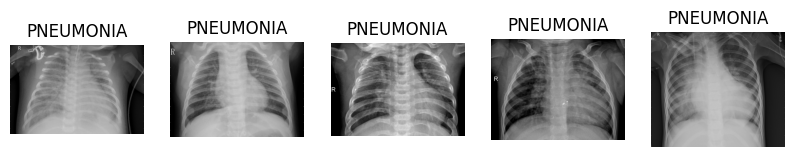

Label directory: chest_xray/chest_xray\train\NORMAL
Sample images: ['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']


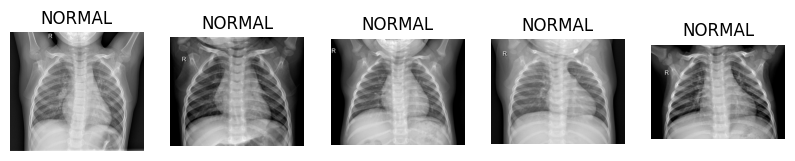

In [3]:
# Load and Explore the Radiography Dataset
base_dir = 'chest_xray/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Debug: Needed to print the directories path to be able to know which directory the data was in 
print(f"Base directory: {base_dir}")
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

# I had issues with the directory paths, so I checked if they exist 
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

# Display a few sample images with labels
def display_sample_images(directory, label, num_samples=5):
    label_dir = os.path.join(directory, label)
    print(f"Label directory: {label_dir}")
    sample_images = os.listdir(label_dir)[:num_samples]
    print(f"Sample images: {sample_images}")
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(label_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

display_sample_images(train_dir, 'PNEUMONIA')
display_sample_images(train_dir, 'NORMAL')

Data processing and Generators

In [4]:
# Preprocess the Data
img_size = (224, 224)

def preprocess_image(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize(img_size)  # Resize image
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


CNN Model with Keras

In [5]:
# Build a Simple CNN Model with Keras
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

c:\Users\user\OneDrive - JUNIA Grande école d'ingénieurs\Documents\M2 SEM 2\AI\ai_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MODEL TRAINING PHASE WITH 10 EPOCHS ( TAKES QUITE SOMETIME)

In [6]:
 #Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

c:\Users\user\OneDrive - JUNIA Grande école d'ingénieurs\Documents\M2 SEM 2\AI\ai_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8327 - loss: 0.3688 - val_accuracy: 0.9540 - val_loss: 0.1254
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9648 - loss: 0.1011 - val_accuracy: 0.9626 - val_loss: 0.0993
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9746 - loss: 0.0720 - val_accuracy: 0.9597 - val_loss: 0.0999
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9814 - loss: 0.0560 - val_accuracy: 0.9453 - val_loss: 0.1626
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9869 - loss: 0.0362 - val_accuracy: 0.9664 - val_loss: 0.1040
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 131s 998ms/step - accuracy: 0.9920 - loss: 0.0268 - val_accuracy: 0.9521 - val_loss: 0.1426
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9930 - loss: 0.0248 - val_accuracy: 0.9684 - val_loss: 0.1456
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 987ms/step - accuracy: 0.9964 - loss: 0.0103 - va

LOSS AND ACCURACY : Plotted Diagram


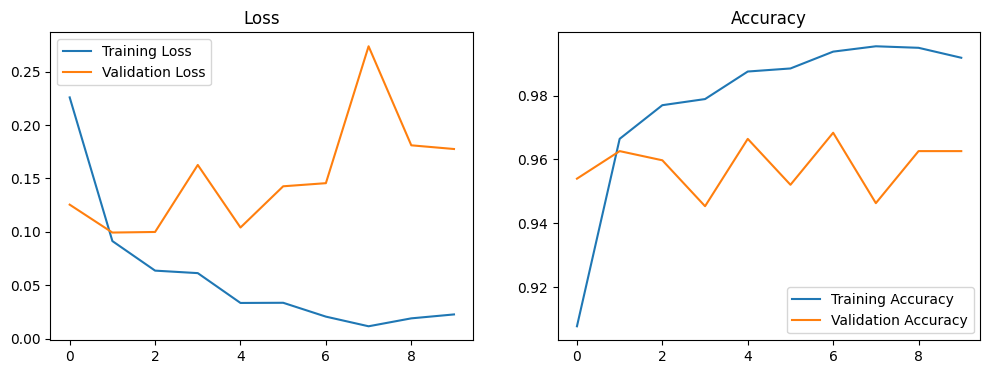

In [7]:
# Show loss & accuracy graphs using matplotlib
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

Predictions : 
Took random images from the internet both with normal lungs and that of pneumonia, change the image path and run to see the prediciton Normal or pneumonia. 

In [11]:
# Make Predictions
def predict_image(model, img_path):
    img = preprocess_image(img_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    confidence = prediction[0][0]
    label = 'PNEUMONIA' if confidence > 0.5 else 'NORMAL'
    return label, confidence

# Upload a sample X-ray image and classify it
sample_img_path = 'amimage.jpg'  # Replace with the path to your sample image
label, confidence = predict_image(model, sample_img_path)
print(f'Prediction: {label}, Confidence: {confidence:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: PNEUMONIA, Confidence: 1.00
